# Machine Learning Engineer - Udacity nanodegree program - Final Project

## Intro 
This Jupter Notebook Phython file contains all the code needed to ground the analysis and conclusion of the `finalproject.pdf` work contained in the main folder of this Gitlab repo.

## work
The work done in this notebook is hereby summarized:

#### IMPORTS
Imports of all the modules and libraries needed. All of them is contained in the Anaconda framework. If you want to run this notebook and do not have the Anaconda installed in your computer, please refer to the installation guide in this link: https://www.anaconda.com/distribution/

#### Dataset reading
Dataset contained in the .csv file importing

#### Data analysis
Analysis of the dataset as data distribution, outliers etc.

#### Development
Work done based on 4 Machine Learning supervised methods:
1. GradientBoostingClassifier
2. RandomForestClassifier
3. LogisticRegression
4. SVC

#### Conclusion
Choise of the best method for this dataset.

----------------------------------------------------------------------------

## Imports and dataset reading

In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import classification_report

%matplotlib notebook

In [2]:
#CSV reading
dataset = pd.read_csv("heart_original.csv", sep=",", encoding="ISO-8859-1")

#File glimpse
dataset.head(10)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


## Data Analysis

Lets search for missing values in the dataset.

In [3]:
for feature in dataset.columns:
    print("{} missing values in the {} column".format(dataset[feature].isnull().sum(), feature))
    

0 missing values in the age column
0 missing values in the sex column
0 missing values in the cp column
0 missing values in the trestbps column
0 missing values in the chol column
0 missing values in the fbs column
0 missing values in the restecg column
0 missing values in the thalach column
0 missing values in the exang column
0 missing values in the oldpeak column
0 missing values in the slope column
0 missing values in the ca column
0 missing values in the thal column
0 missing values in the target column


Great! No missing values in the dataset. Now lets look how the numeric data is distributed and if there are outliers to be removed.

In [4]:
dataset.target.value_counts()


1    165
0    138
Name: target, dtype: int64

The target variable is well distributed as we can see above, so we can use the standard accuracy method to validate our model. How about the oter features?

<IPython.core.display.Javascript object>


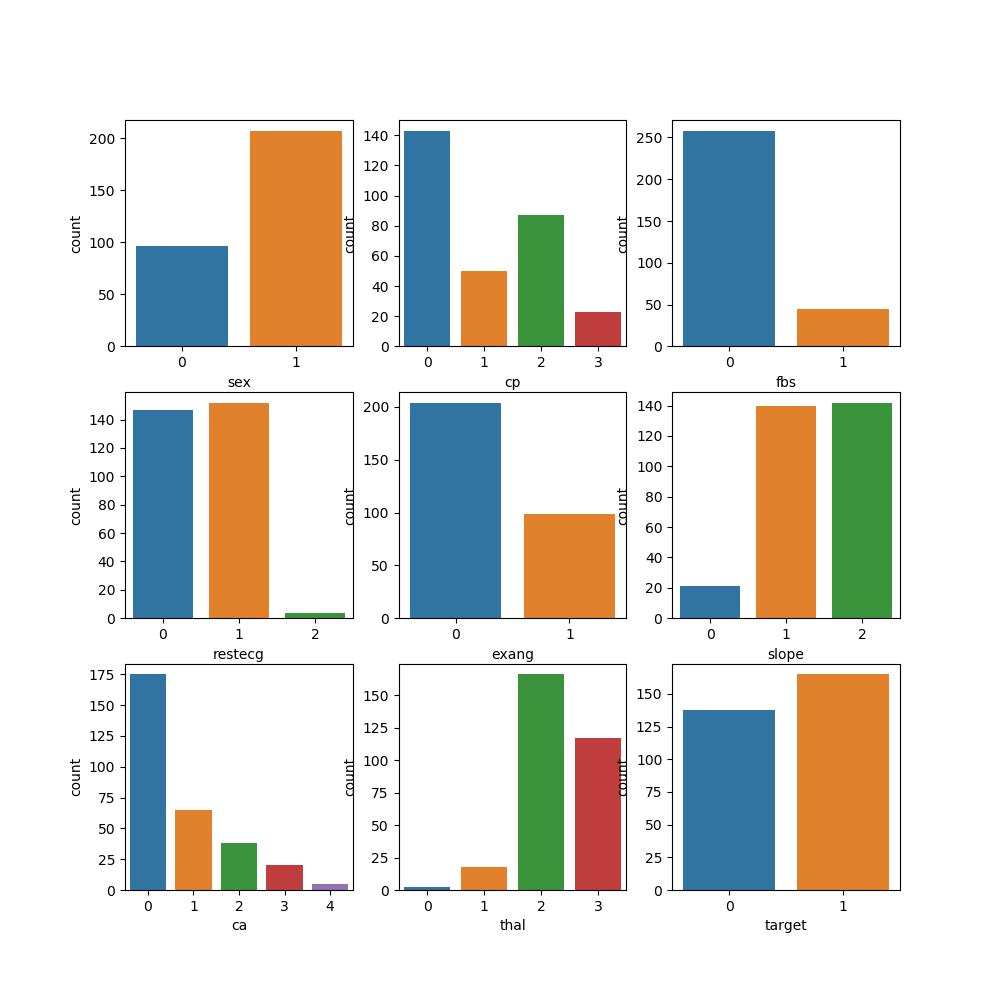

In [5]:
fig, ax = plt.subplots(3,3, figsize=(10, 10))
sb.countplot(dataset['sex'], ax=ax[0][0])
sb.countplot(dataset['cp'], ax=ax[0][1])
sb.countplot(dataset['fbs'], ax=ax[0][2])
sb.countplot(dataset['restecg'], ax=ax[1][0])
sb.countplot(dataset['exang'], ax=ax[1][1])
sb.countplot(dataset['slope'], ax=ax[1][2])
sb.countplot(dataset['ca'], ax=ax[2][0])
sb.countplot(dataset['thal'], ax=ax[2][1])
sb.countplot(dataset['target'], ax=ax[2][2])
fig.show()

It may be reasonable to look at the confusion matrix and use the F1 score for validation, since the imbalanced features may interfere.

Now let's look at the outliers. 

We just want to look for outliers in numerical "wide range" variables as trestbps, chol and thalach.

In [6]:
# Create a ouliers removal rotine, since it will be running 3 times, one for each feature
def remove_outliers(data_frame ,label, condition=1.5):
    q75, q25 = np.percentile(data_frame.loc[:,label], [75,25])
    iqr = q75 - q25
    qnty_before = data_frame[label].count()
    print("{} quantity before outliers removal: {}".format(label, qnty_before))
    data_frame.drop(data_frame[data_frame[label] < (q25-condition*iqr)].index, inplace=True)
    data_frame.drop(data_frame[data_frame[label] > (q75+condition*iqr)].index, inplace=True)
    qnty_after = data_frame[label].count()
    print("{} quantity after outliers removal: {}".format(label, qnty_after))
    print("Percent of removed values: {:0.2f}%".format((1-qnty_after/qnty_before)*100))

# We dont want to mess with the real dataset, so lets make a copy
outlier_dataset = dataset.copy()
original_size = outlier_dataset['age'].count()
remove_outliers(outlier_dataset, 'age')
remove_outliers(outlier_dataset, 'trestbps')
remove_outliers(outlier_dataset, 'chol')
remove_outliers(outlier_dataset, 'thalach')
new_size = outlier_dataset['age'].count()
print("Percent of total removed values: {:0.2f}%".format((1-new_size/original_size)*100))



age quantity before outliers removal: 303
age quantity after outliers removal: 303
Percent of removed values: 0.00%
trestbps quantity before outliers removal: 303
trestbps quantity after outliers removal: 294
Percent of removed values: 2.97%
chol quantity before outliers removal: 294
chol quantity after outliers removal: 289
Percent of removed values: 1.70%
thalach quantity before outliers removal: 289
thalach quantity after outliers removal: 288
Percent of removed values: 0.35%
Percent of total removed values: 4.95%


4.95% of data loss is not a number to ignore. Lets make a softer condition to the outliers removal and see if we lose less data and remove the "real" outliers. 

In [7]:
# Changing the standard condition value of 1.5 to 2
outlier_dataset2 = dataset.copy()
condition = 2
original_size = outlier_dataset2['age'].count()
remove_outliers(outlier_dataset2, 'age', condition = condition)
remove_outliers(outlier_dataset2, 'trestbps', condition = condition)
remove_outliers(outlier_dataset2, 'chol', condition = condition)
remove_outliers(outlier_dataset2, 'thalach', condition = condition)
new_size = outlier_dataset2['age'].count()
print("Percent of total removed values: {:0.2f}%".format((1-new_size/original_size)*100))

age quantity before outliers removal: 303
age quantity after outliers removal: 303
Percent of removed values: 0.00%
trestbps quantity before outliers removal: 303
trestbps quantity after outliers removal: 301
Percent of removed values: 0.66%
chol quantity before outliers removal: 301
chol quantity after outliers removal: 297
Percent of removed values: 1.33%
thalach quantity before outliers removal: 297
thalach quantity after outliers removal: 297
Percent of removed values: 0.00%
Percent of total removed values: 1.98%


Now it seems ok. 1.98% of data loss is acceptable and won't be a problem to our prediction model. Still, the the most significant outliers were removed.

Next step: Plot data distribution to see how skewed they are.

<IPython.core.display.Javascript object>


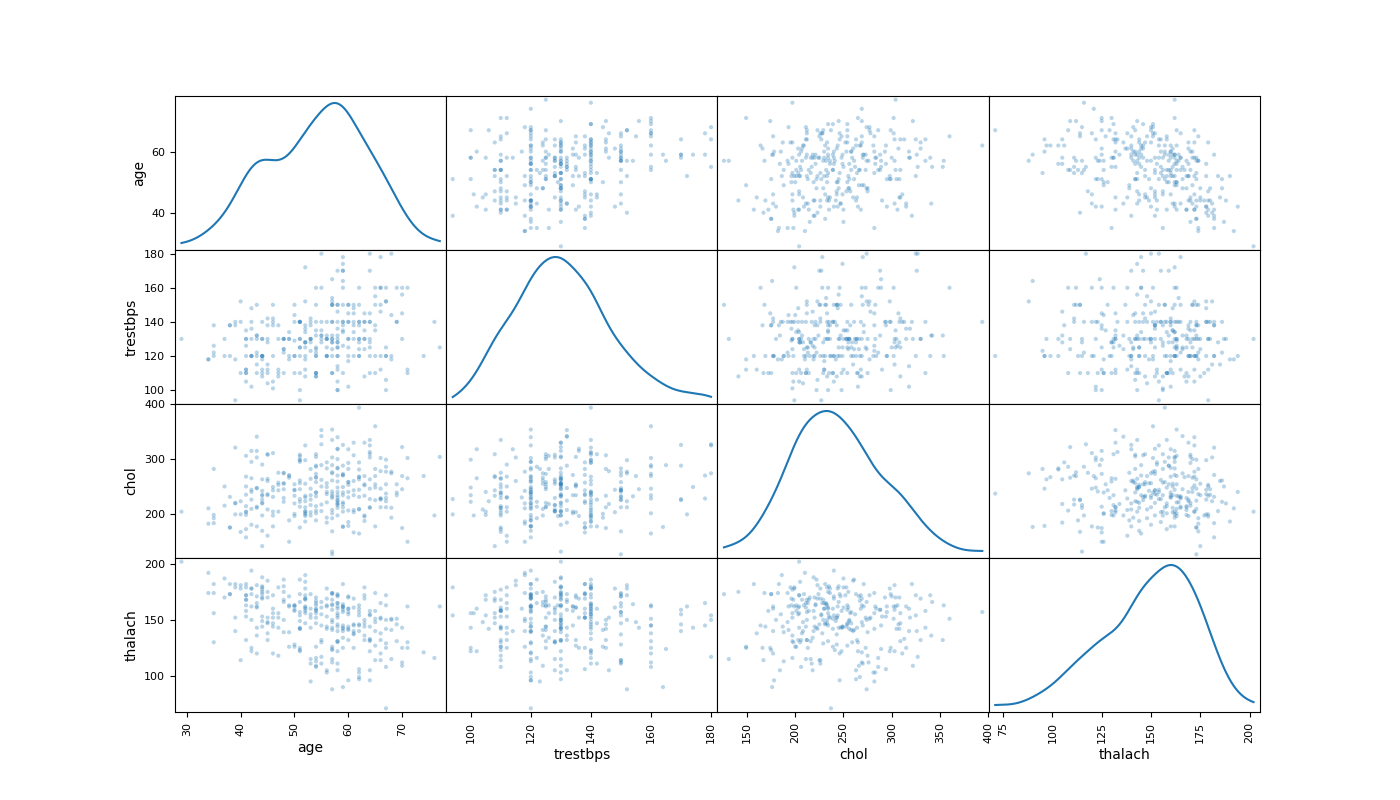

In [8]:
numerical_widerange = outlier_dataset2.copy()
numerical_widerange = numerical_widerange.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'], axis=1)
pd.plotting.scatter_matrix(numerical_widerange, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

It is possible to see that all features being analysed are skewed either to left and to right. Lets apply a log tranformation to see if it helps to straighten the curve. 

We need to see if there is any feature with zero values. If positive, we need to chance it to a small positive number like "0.000001" in order to apply the log transformation.

<IPython.core.display.Javascript object>


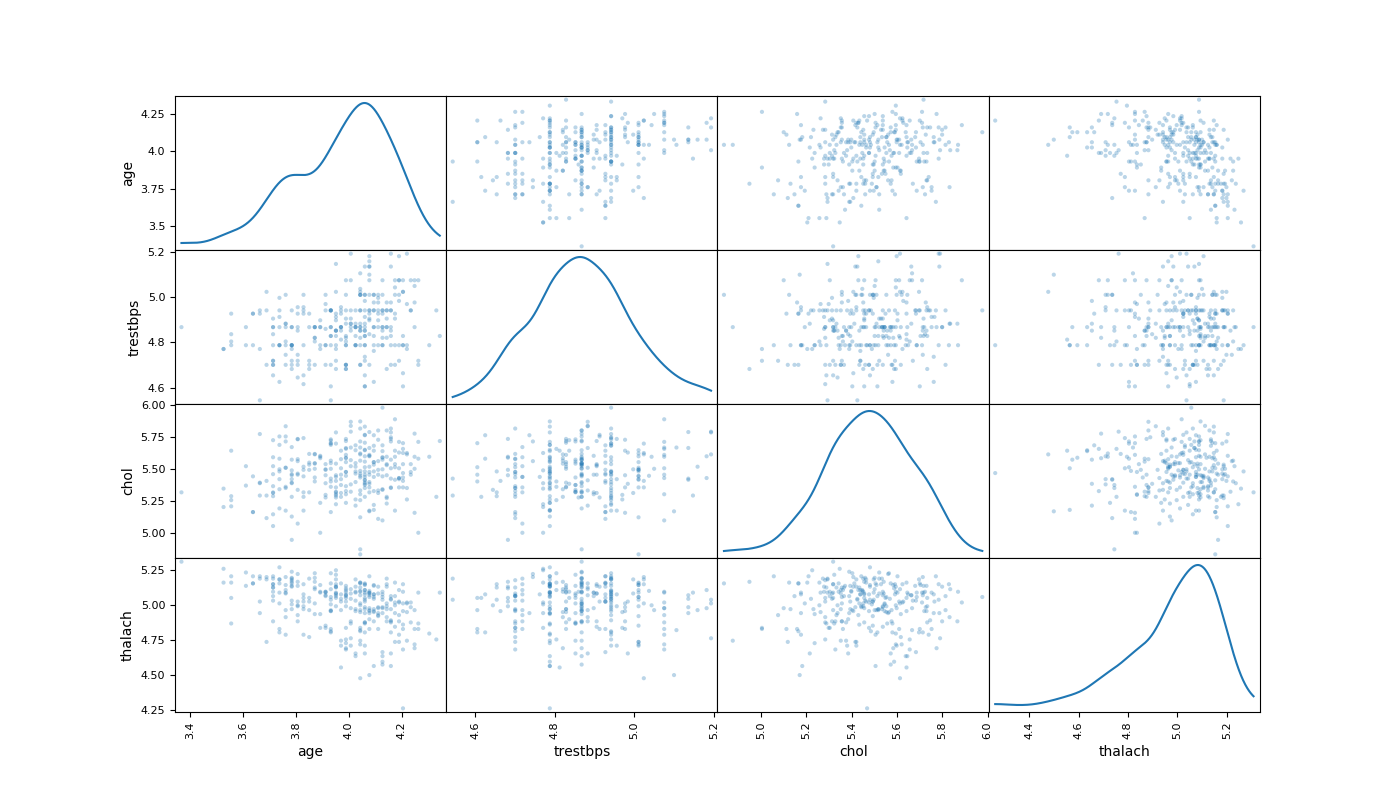

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1bdedc50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1a2930b8>]], dtype=object)

In [9]:
log_dataset = np.log(numerical_widerange)
pd.plotting.scatter_matrix(log_dataset, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

# Machine learning models

Now we will run all the 3 datasets (original, outliers removed and outliers removed with log transformation) on 4 Machine Learning supervised methods:
1. GradientBoostingClassifier
2. RandomForestClassifier
3. LogisticRegression
4. SVC

Lets start spliting the dataset into 2 subsets one for training and the other for testing.

In [20]:
#DATA SPLIT
y = dataset['target'].values
X = dataset.drop(['target'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [21]:
parameters = {'min_samples_leaf':(1, 5, 10, 20), 'n_estimators':[20, 50, 100, 150]}
model = GradientBoostingClassifier()
GBC_clf = GridSearchCV(model, parameters, cv=5)
GBC_clf.fit(X_train, y_train)
pred = GBC_clf.predict(X_test)
GBC_accuracy = np.mean(pred == y_test)
GBC_f1 = f1_score(y_test, pred)

print("Accuracy: {:0.2f}".format(GBC_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.84
             precision    recall  f1-score   support

          0       0.84      0.78      0.81        41
          1       0.83      0.88      0.85        50

avg / total       0.84      0.84      0.83        91



In [22]:
parameters = {'min_samples_leaf':(1, 5, 10, 20), 'n_estimators':[20, 50, 100, 150]}
model = RandomForestClassifier()
RFC_clf = GridSearchCV(model, parameters, cv=5)
RFC_clf.fit(X_train, y_train)
pred = RFC_clf.predict(X_test)
RFC_accuracy = np.mean(pred == y_test)
RFC_f1 = f1_score(y_test, pred)

print("Accuracy: {:0.2f}".format(RFC_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.84
             precision    recall  f1-score   support

          0       0.84      0.78      0.81        41
          1       0.83      0.88      0.85        50

avg / total       0.84      0.84      0.83        91



In [23]:
parameters = {'penalty':['l1','l2'], 'C':[0.1, 0.5, 1.0, 5.0]}
model = LogisticRegression()
LR_clf = GridSearchCV(model, parameters, cv=5)
LR_clf.fit(X_train, y_train)
pred = LR_clf.predict(X_test)
LR_accuracy = np.mean(pred == y_test)
LR_f1 = f1_score(y_test, pred)

print("Accuracy: {:0.2f}".format(LR_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.81
             precision    recall  f1-score   support

          0       0.80      0.78      0.79        41
          1       0.82      0.84      0.83        50

avg / total       0.81      0.81      0.81        91



In [24]:
parameters = {'kernel':['linear', 'rbf', 'sigmoid'], 'C':[0.5, 1.0]}
model = SVC()
SVC_clf = GridSearchCV(model, parameters, cv=5)
SVC_clf.fit(X_train, y_train)
pred = SVC_clf.predict(X_test)
SVC_accuracy = np.mean(pred == y_test)
SVC_f1 = f1_score(y_test, pred)
SVC_recall = recall_score(y_test, pred)

print("Accuracy: {:0.2f}".format(SVC_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.82
             precision    recall  f1-score   support

          0       0.80      0.80      0.80        41
          1       0.84      0.84      0.84        50

avg / total       0.82      0.82      0.82        91



In [28]:
print("GBC params:")
print(GBC_clf.get_params())
print("\n RFC params:")
print(RFC_clf.get_params())
print("\n LF params:")
print(LR_clf.get_params())
print("\n SVC params:")
print(SVC_clf.get_params())

GBC params:
{'cv': 5, 'error_score': 'raise', 'estimator__criterion': 'friedman_mse', 'estimator__init': None, 'estimator__learning_rate': 0.1, 'estimator__loss': 'deviance', 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__presort': 'auto', 'estimator__random_state': None, 'estimator__subsample': 1.0, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.

In [29]:
#DATA SPLIT
y = outlier_dataset2['target'].values
X = outlier_dataset2.drop(['target'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [30]:
parameters = {'min_samples_leaf':(1, 5, 10, 20), 'n_estimators':[20, 50, 100, 150]}
model = GradientBoostingClassifier()
GBC_clf = GridSearchCV(model, parameters, cv=5)
GBC_clf.fit(X_train, y_train)
pred = GBC_clf.predict(X_test)
GBC_accuracy = np.mean(pred == y_test)
GBC_f1 = f1_score(y_test, pred)
GBC_recall = recall_score(y_test, pred)

print("Accuracy: {:0.2f}".format(GBC_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.79
             precision    recall  f1-score   support

          0       0.76      0.74      0.75        38
          1       0.81      0.83      0.82        52

avg / total       0.79      0.79      0.79        90



In [31]:
parameters = {'min_samples_leaf':(1, 5, 10, 20), 'n_estimators':[20, 50, 100, 150]}
model = RandomForestClassifier()
RFC_clf = GridSearchCV(model, parameters, cv=5)
RFC_clf.fit(X_train, y_train)
pred = RFC_clf.predict(X_test)
RFC_accuracy = np.mean(pred == y_test)
RFC_f1 = f1_score(y_test, pred)

print("Accuracy: {:0.2f}".format(RFC_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.80
             precision    recall  f1-score   support

          0       0.79      0.71      0.75        38
          1       0.80      0.87      0.83        52

avg / total       0.80      0.80      0.80        90



In [35]:
parameters = {'penalty':['l1','l2'], 'C':[0.1, 0.5, 1.0, 5.0]}
model = LogisticRegression()
LR_clf = GridSearchCV(model, parameters, cv=5)
LR_clf.fit(X_train, y_train)
pred = LR_clf.predict(X_test)
LR_accuracy = np.mean(pred == y_test)
print("Accuracy: {:0.2f}".format(LR_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.83
             precision    recall  f1-score   support

          0       0.87      0.71      0.78        38
          1       0.81      0.92      0.86        52

avg / total       0.84      0.83      0.83        90



In [36]:
parameters = {'kernel':['linear', 'rbf', 'sigmoid'], 'C':[0.5, 1.0]}
model = SVC()
SVC_clf = GridSearchCV(model, parameters, cv=5)
SVC_clf.fit(X_train, y_train)
pred = SVC_clf.predict(X_test)
SVC_accuracy = np.mean(pred == y_test)
print("Accuracy: {:0.2f}".format(SVC_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.82
             precision    recall  f1-score   support

          0       0.84      0.71      0.77        38
          1       0.81      0.90      0.85        52

avg / total       0.82      0.82      0.82        90



In [37]:
print("GBC params:")
print(GBC_clf.get_params())
print("\n RFC params:")
print(RFC_clf.get_params())
print("\n LF params:")
print(LR_clf.get_params())
print("\n SVC params:")
print(SVC_clf.get_params())

GBC params:
{'cv': 5, 'error_score': 'raise', 'estimator__criterion': 'friedman_mse', 'estimator__init': None, 'estimator__learning_rate': 0.1, 'estimator__loss': 'deviance', 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__presort': 'auto', 'estimator__random_state': None, 'estimator__subsample': 1.0, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.

In [38]:
log_dataset = pd.concat([log_dataset, outlier_dataset2[['sex', 'cp', 'fbs', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']]], axis=1)
log_dataset.head()

,age,trestbps,chol,thalach,sex,cp,fbs,restecg,exang,oldpeak,slope,ca,thal,target
0,4.143135,4.976734,5.451038,5.010635,1,3,1,0,0,2.3,0,0,1,1
1,3.610918,4.867534,5.521461,5.231109,1,2,0,1,0,3.5,0,0,2,1
2,3.713572,4.867534,5.318120,5.147494,0,1,0,0,0,1.4,2,0,2,1
3,4.025352,4.787492,5.463832,5.181784,1,1,0,1,0,0.8,2,0,2,1
4,4.043051,4.787492,5.869297,5.093750,0,0,0,1,1,0.6,2,0,2,1


In [39]:
#DATA SPLIT
y = log_dataset['target'].values
X = log_dataset.drop(['target'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
#MODELS with grid search
# GradientBoostingClassifier
parameters = {'random_state':(39, 42), 'n_estimators':[20, 50, 100, 150]}
model = GradientBoostingClassifier()
GBC_clf = GridSearchCV(model, parameters, cv=5)
GBC_clf.fit(X_train, y_train)
pred = GBC_clf.predict(X_test)
GBC_accuracy = np.mean(pred == y_test)

print("Accuracy: {:0.2f}".format(GBC_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.80
             precision    recall  f1-score   support

          0       0.78      0.74      0.76        38
          1       0.81      0.85      0.83        52

avg / total       0.80      0.80      0.80        90



In [41]:
parameters = {'random_state':(39, 42), 'n_estimators':[20, 50, 100, 150]}
model = RandomForestClassifier()
RFC_clf = GridSearchCV(model, parameters, cv=5)
RFC_clf.fit(X_train, y_train)
pred = RFC_clf.predict(X_test)
RFC_accuracy = np.mean(pred == y_test)

print("Accuracy: {:0.2f}".format(RFC_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.80
             precision    recall  f1-score   support

          0       0.73      0.84      0.78        38
          1       0.87      0.77      0.82        52

avg / total       0.81      0.80      0.80        90



In [42]:
parameters = {'penalty':['l1','l2'], 'C':[0.1, 0.5, 1.0, 5.0]}
model = LogisticRegression()
LR_clf = GridSearchCV(model, parameters, cv=5)
LR_clf.fit(X_train, y_train)
pred = LR_clf.predict(X_test)
LR_accuracy = np.mean(pred == y_test)

print("Accuracy: {:0.2f}".format(LR_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.80
             precision    recall  f1-score   support

          0       0.81      0.68      0.74        38
          1       0.79      0.88      0.84        52

avg / total       0.80      0.80      0.80        90



In [43]:
parameters = {'kernel':['linear', 'rbf', 'sigmoid'], 'C':[0.5, 1.0]}
model = SVC()
SVC_clf = GridSearchCV(model, parameters, cv=5)
SVC_clf.fit(X_train, y_train)
pred = SVC_clf.predict(X_test)
SVC_accuracy = np.mean(pred == y_test)

print("Accuracy: {:0.2f}".format(SVC_accuracy))
print(classification_report(y_test, pred))

Accuracy: 0.84
             precision    recall  f1-score   support

          0       0.88      0.74      0.80        38
          1       0.83      0.92      0.87        52

avg / total       0.85      0.84      0.84        90



In [44]:
print("GBC params:")
print(GBC_clf.get_params())
print("\n RFC params:")
print(RFC_clf.get_params())
print("\n LF params:")
print(LR_clf.get_params())
print("\n SVC params:")
print(SVC_clf.get_params())

GBC params:
{'cv': 5, 'error_score': 'raise', 'estimator__criterion': 'friedman_mse', 'estimator__init': None, 'estimator__learning_rate': 0.1, 'estimator__loss': 'deviance', 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__presort': 'auto', 'estimator__random_state': None, 'estimator__subsample': 1.0, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.